# Fine-tuning a RBF model for a regression problem

In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

from keras.datasets import boston_housing
from keras import Model, layers
from keras.metrics import RootMeanSquaredError
from keras import backend as K

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
from scipy.spatial.distance import cdist

import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

## Useful functions

In [20]:
# Function that finds the centers of the neurons with kmeans
def find_centers(num_neurons, train):
    kmeans = KMeans(n_clusters=num_neurons, n_init=10).fit(train)
    centers = kmeans.cluster_centers_
    return centers

In [21]:
# The radial basis function layer
# x is the input of the layer and c is the centers of the rbf neurons
# The function returns the outputs of the rbf layer as a NxM matrix where N is the length of x and M is the length of c
def rbf_layer(x, c):
    rbf_neurons = np.shape(c)[0]

    # Find sigma
    d_max = cdist(c, c, metric="euclidean").max()
    sigma = d_max / np.sqrt(2 * rbf_neurons)

    # Stores the transformed set x after it passes the rbf layer
    transformed_x = np.zeros([np.shape(x)[0], rbf_neurons], dtype=np.float32)

    # Pass the x set through every rbf neuron
    for i, center in enumerate(c):
        # Find the squared norms
        norms = np.linalg.norm((x - center), axis=1) ** 2

        transformed_x[:, i] = np.exp(-norms) / (2 * (sigma**2))

    return transformed_x

In [22]:
# Function that plots figures based on the history of the training
def loss_acc_plot(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title('Loss of train and validation sets')

    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label='Train')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
    plt.legend()
    plt.title('RMSE of train and validation sets')

    plt.show()

In [36]:
def prediction_metrics(xtest, ytest, model, centers):
    xtest_transformed = rbf_layer(xtest, centers)
    
    ypred = model.predict(xtest_transformed)
    
    r2 = r2_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    rmse = np.sqrt(mse)
    
    print('The metrics for the testing set are:')
    print(f'Rsquared: {r2}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    
    return

## Data Preprocessing

In [23]:
# Preparation of boston housing data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=0.25)

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
y_train, y_test = np.array(y_train, np.float32), np.array(y_test, np.float32)

# Scale the training and testing data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
def build_model(n_h1, n_h2, dropout, lr):
    model = keras.Sequential([
        keras.layers.Dense(n_h2, input_shape=(n_h1,), activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optim = keras.optimizers.SGD(learning_rate=lr)
    loss_func = keras.losses.MeanSquaredError()

    model.compile(optimizer=optim, loss=loss_func, metrics=[RootMeanSquaredError()])
    
    return model

In [25]:
def fine_tuning(xtrain, ytrain):
    # Percentages of the RBF neurons based on the length of the training data
    n_h1_perc = np.array([0.05, 0.15, 0.3, 0.5])
    # Number of possible RBF neurons
    n_h1 = n_h1_perc * np.shape(ytrain)[0]
    n_h1 = n_h1.astype(int)
    
    # Number of possible neurons on the output layer
    n_h2 = np.array([32, 64, 128, 256])
    
    dropout = np.array([0.2, 0.35, 0.5])
    lr = 0.001
    epochs = 100
    
    # The 5-fold Cross Validation splitter
    kf = KFold(n_splits=5, shuffle=True)
    
    # Variables to hold the best values for the grid search
    best_n_h1_perc = 0
    best_n_h2 = 0
    best_dropout = 0
    best_rmse = float('inf')
    
    # Holds the rmse of the 5-folds
    fold_rmse = np.empty(5)
    
    for i, hidden1 in enumerate(n_h1):
        centers = find_centers(hidden1, xtrain)

        # Pass the train set from the rbf layer
        x_transformed = rbf_layer(xtrain, centers)
        
        for hidden2 in n_h2:
            for drop in dropout:
                print(f'For {n_h1_perc[i]}%, for {hidden2} and dropout {drop}')
                for j, (train, valid) in enumerate(kf.split(x_transformed, ytrain)):
                    
                    model = build_model(hidden1, hidden2, drop, lr)
                    
                    history = model.fit(x_transformed[train], ytrain[train], epochs=epochs, verbose=0)   
                    
                    score = model.evaluate(x_transformed[valid], ytrain[valid])
                    
                    fold_rmse[j] = score[1]
                
                rmse = np.mean(fold_rmse)
                print(f'Current mean RMSE: {rmse}')
                
                if best_rmse > rmse:
                    best_rmse = rmse
                    best_dropout = drop
                    best_n_h1_perc = n_h1_perc[i]
                    best_n_h2 = hidden2
                    
    return best_n_h1_perc, best_n_h2, best_dropout, best_rmse

In [26]:
st = time.time()

best_n_h1_perc, best_n_h2, best_dropout, best_rmse = fine_tuning(x_train, y_train)

end = time.time()

print('Fine-tuning time execution:', end-st, 'seconds')

print(f'Best RMSE (mean of 5-fold) is: {best_rmse}')

print('The optimal values acquired by the fine-tuning function are:')
print(f'Best percentage of RBF neurons based on the size of the training data {best_n_h1_perc*100}%')
print(f'Best number of neurons in the output layer is: {best_n_h2} neurons')
print(f'Best dropout probability is: {best_dropout}')

For 0.05%, for 32 and dropout 0.2
3/3 [==============================] - 0s 7ms/step - loss: 111.8226 - root_mean_squared_error: 10.5746
Current mean RMSE: 9.417309379577636
For 0.05%, for 32 and dropout 0.35
3/3 [==============================] - 0s 7ms/step - loss: 92.3261 - root_mean_squared_error: 9.6086
Current mean RMSE: 9.344313430786134
For 0.05%, for 32 and dropout 0.5
3/3 [==============================] - 0s 6ms/step - loss: 91.2336 - root_mean_squared_error: 9.5516
Current mean RMSE: 9.356036949157716
For 0.05%, for 64 and dropout 0.2
3/3 [==============================] - 0s 6ms/step - loss: 119.3581 - root_mean_squared_error: 10.9251
Current mean RMSE: 9.31252841949463
For 0.05%, for 64 and dropout 0.35
3/3 [==============================] - 0s 7ms/step - loss: 77.2712 - root_mean_squared_error: 8.7904
Current mean RMSE: 9.31697998046875
For 0.05%, for 64 and dropout 0.5
3/3 [==============================] - 0s 6ms/step - loss: 91.7088 - root_mean_squared_error: 9.5765
C

# Train best model

Number of RBR neurons: 189
Epoch 1/100
10/10 [==============================] - 1s 35ms/step - loss: 536.1615 - root_mean_squared_error: 23.1552 - val_loss: 729.2001 - val_root_mean_squared_error: 27.0037
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 500.7063 - root_mean_squared_error: 22.3765 - val_loss: 679.8004 - val_root_mean_squared_error: 26.0730
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 451.0683 - root_mean_squared_error: 21.2384 - val_loss: 603.2678 - val_root_mean_squared_error: 24.5615
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 372.8314 - root_mean_squared_error: 19.3088 - val_loss: 491.7173 - val_root_mean_squared_error: 22.1747
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 278.9899 - root_mean_squared_error: 16.7030 - val_loss: 361.1858 - val_root_mean_squared_error: 19.0049
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 178.4429 

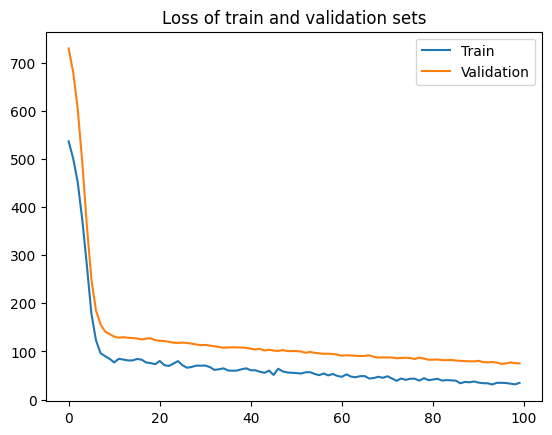

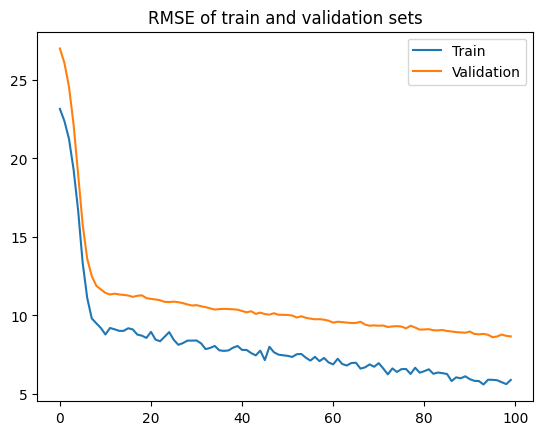

The metrics for the testing set are:
Rsquared: 0.36376035848894595
MSE: 48.3134651184082
RMSE: 6.950788974761963


In [37]:
best_n_h1 = best_n_h1_perc * np.shape(y_train)[0]
best_n_h1 = best_n_h1.astype(int)
print(f'Number of RBR neurons: {best_n_h1}')

centers = find_centers(best_n_h1, x_train)

# Pass the train set from the rbf layer
x_transformed = rbf_layer(x_train, centers)

model = build_model(best_n_h1, best_n_h2, best_dropout, 0.001)

history = model.fit(x_transformed, y_train, epochs=100, validation_split=0.2)   

loss_acc_plot(history)

prediction_metrics(x_test, y_test, model, centers)